# Importing modules and dependences

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit

# Loading VDFs and augmenting them with the particle abundances and power spectrum

In [5]:
featurevector_allvdfs_all_4040 = np.load('allsimulations.mldata_vdfs_4040.npy')
featurevector_allvdfs_all_6060 = np.load('allsimulations.mldata_vdfs_6060.npy')
print(featurevector_allvdfs_all_4040.shape)
print(featurevector_allvdfs_all_6060.shape)

(1596, 2, 40, 40)
(1596, 2, 60, 60)


In [6]:
featurevector_allmoments = np.load('allsimulations.featurevector_allmoments_allps.npy')
print(featurevector_allmoments.shape)
extra_features = featurevector_allmoments[:,18:]

(1596, 30)


In [7]:
ncases = featurevector_allvdfs_all_4040.shape[0]
featurevector_allvdfs_all_4040_norm = np.copy(np.log10(featurevector_allvdfs_all_4040 + 1))
for ncase in range (0, ncases, 1):
  featurevector_allvdfs_all_4040_norm[ncase,0,:,:] /= np.amax(featurevector_allvdfs_all_4040_norm[ncase,0,:,:])
  if (np.amax(featurevector_allvdfs_all_4040_norm[ncase,1,:,:]) != 0):
    featurevector_allvdfs_all_4040_norm[ncase,1,:,:] /= np.amax(featurevector_allvdfs_all_4040_norm[ncase,1,:,:])

ncases = featurevector_allvdfs_all_6060.shape[0]
featurevector_allvdfs_all_6060_norm = np.copy(np.log10(featurevector_allvdfs_all_6060 + 1))
for ncase in range (0, ncases, 1):
  featurevector_allvdfs_all_6060_norm[ncase,0,:,:] /= np.amax(featurevector_allvdfs_all_6060_norm[ncase,0,:,:])
  if (np.amax(featurevector_allvdfs_all_6060_norm[ncase,1,:,:]) != 0):
    featurevector_allvdfs_all_6060_norm[ncase,1,:,:] /= np.amax(featurevector_allvdfs_all_6060_norm[ncase,1,:,:])

In [8]:
ncases = featurevector_allvdfs_all_4040_norm.shape[0]
featurevector_allvdfs_all_4040_aug = np.zeros([ncases,2*40*40+12], dtype=float)
featurevector_allvdfs_all_4040_aug[:,:-12] = np.log10(featurevector_allvdfs_all_4040_norm.reshape(featurevector_allvdfs_all_4040_norm.shape[0], -1) + 1)
featurevector_allvdfs_all_4040_aug[:,-12:] = extra_features

ncases = featurevector_allvdfs_all_6060_norm.shape[0]
featurevector_allvdfs_all_6060_aug = np.zeros([ncases,2*60*60+12], dtype=float)
featurevector_allvdfs_all_6060_aug[:,:-12] = np.log10(featurevector_allvdfs_all_6060_norm.reshape(featurevector_allvdfs_all_6060_norm.shape[0], -1) + 1)
featurevector_allvdfs_all_6060_aug[:,-12:] = extra_features

print(featurevector_allvdfs_all_4040_aug.shape)
print(featurevector_allvdfs_all_6060_aug.shape)
print(np.amin(featurevector_allvdfs_all_6060_aug[:,-10:]))
print(np.amax(featurevector_allvdfs_all_6060_aug[:,-10:]))

(1596, 3212)
(1596, 7212)
0.00020191832627305094
1.0


In [9]:
featurevector_allmoments = np.load('allsimulations.featurevector_allmoments_all.npy')
times_allmoments = np.load('allsimulations.timep_array_all.npy')
labels_an = np.load('allsimulations.labels_allmoments_an_01_all.npy')
labels_me = np.load('allsimulations.labels_allmoments_me_01_all.npy')
# merging both labels
labels_allmoments = np.copy(labels_me)
labels_allmoments[np.where(labels_an == 1)] = 1

print('The total number of data points is: ' + str(len(labels_allmoments)))
print('Among them unstable (positive) samples: ' + str(len(np.where(labels_allmoments == 1)[0])))

print(labels_allmoments.shape)

The total number of data points is: 1596
Among them unstable (positive) samples: 418
(1596,)


In [10]:
simnames = np.load('allsimulations.simnames_all.npy')

In [11]:
data_split = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)
data_split.split(labels_allmoments)

<generator object BaseShuffleSplit.split at 0x79e0d4127e40>

# Best architecture for 40x40 VDFs (5-fold CV for faster assessment)

In [12]:
class VDFCNN_4040_CNN3_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN3_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*5*5+12, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 16 * 5 * 5)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN3_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN3_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*5*5+12, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 16 * 5 * 5)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN2_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN2_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*10*10+12, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 8 * 10 * 10)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN2_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN2_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*10*10+12, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 8 * 10 * 10)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN1_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN1_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(4*20*20+12, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 4 * 20 * 20)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN1_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN1_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(4*20*20+12, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 4 * 20 * 20)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x

In [13]:
def outputclass_analysis_scorereturn(test_labels, predicted_labels):
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    acc = (tp+tn)/(tp+fn+fp+tn)
    tss = tp/(tp+fn) - fp/(fp+tn)
    hss = 2*(tp*tn - fp*fn)/((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    return tp, tn, fp, fn, acc, tss

100%|██████████| 2000/2000 [01:27<00:00, 22.87it/s]


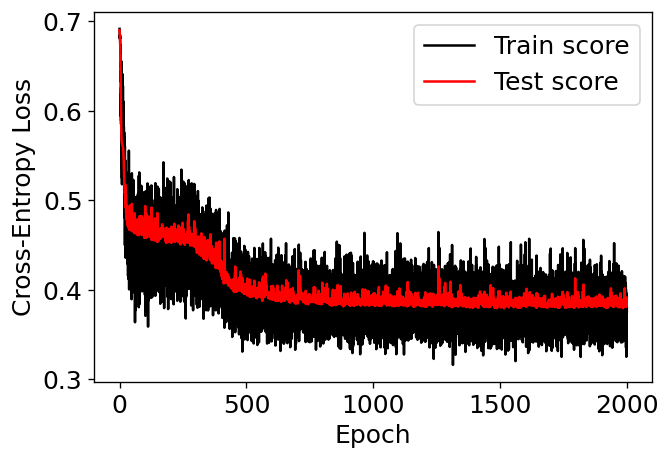

250 0.8519924098671727 0.5330712568222588
500 0.9146110056925996 0.7662493797946643
750 0.9297912713472486 0.7915346742490744
1000 0.9240986717267552 0.7938819129040876
1250 0.9316888045540797 0.8040341971680469
1500 0.9278937381404174 0.7989580550360673
1750 0.9316888045540797 0.7990534712415557
---------------------------------------------


100%|██████████| 2000/2000 [01:22<00:00, 24.20it/s]


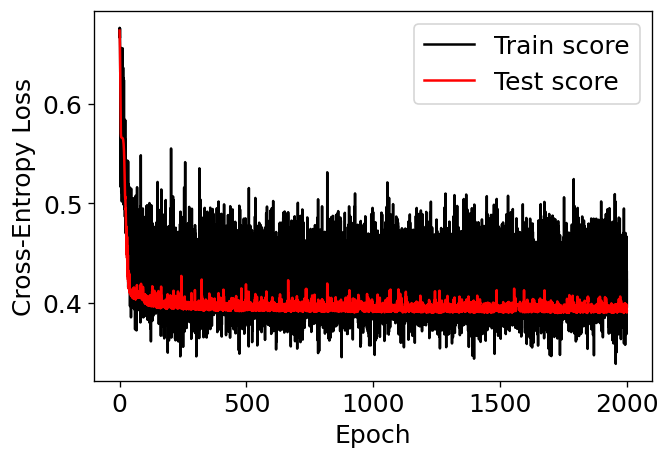

250 0.9146110056925996 0.6965192168237854
500 0.9127134724857685 0.6890004198313041
750 0.9222011385199241 0.6917293233082706
1000 0.9184060721062619 0.6866531811762909
1250 0.9222011385199241 0.6967100492347621
1500 0.9165085388994307 0.6990572878897752
1750 0.9278937381404174 0.7142857142857143
---------------------------------------------


100%|██████████| 2000/2000 [01:22<00:00, 24.24it/s]


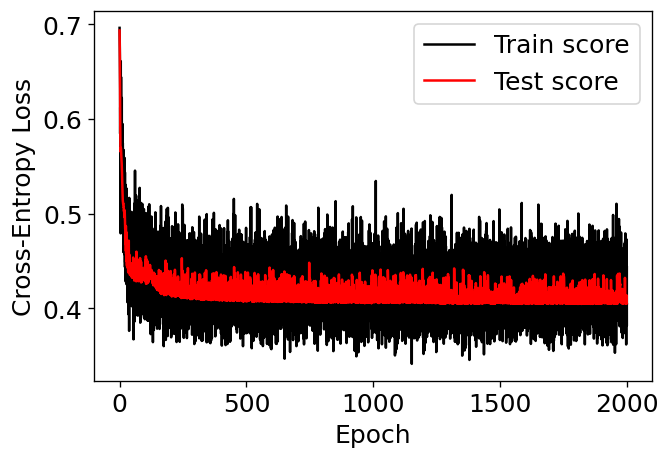

RERUNNING THE SAMPLE...


100%|██████████| 2000/2000 [01:23<00:00, 23.94it/s]


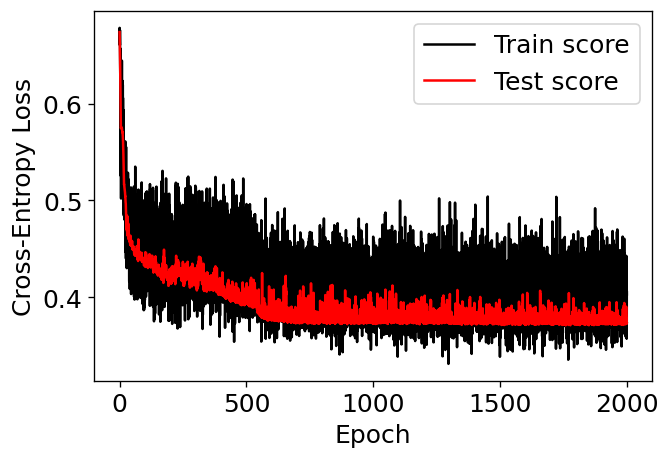

250 0.8956356736242884 0.6597196469628421
500 0.920303605313093 0.7532448268189572
750 0.9392789373814042 0.7928687977453089
1000 0.9430740037950665 0.7887895868871913
1250 0.9430740037950665 0.7980234369205667
1500 0.9430740037950665 0.7980234369205667
1750 0.9468690702087287 0.8077950011125121
---------------------------------------------


100%|██████████| 2000/2000 [01:23<00:00, 23.97it/s]


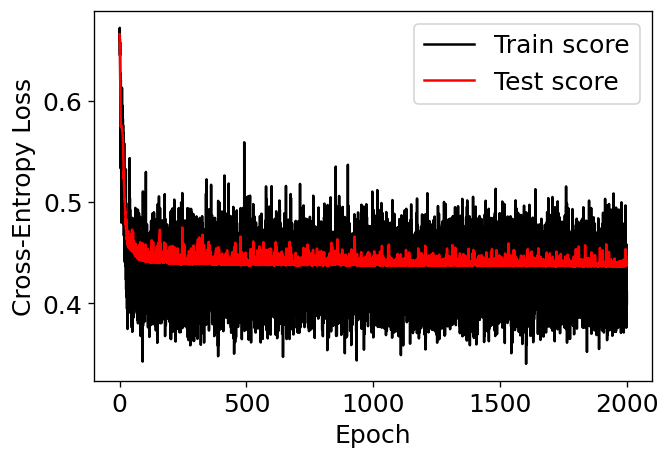

RERUNNING THE SAMPLE...


100%|██████████| 2000/2000 [01:23<00:00, 24.09it/s]


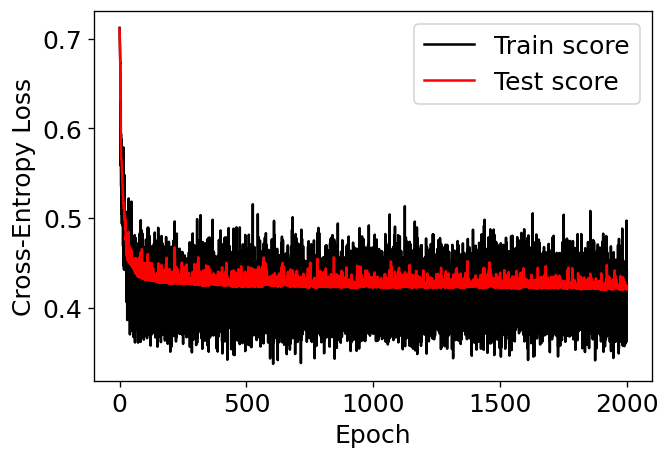

250 0.8918406072106262 0.6293281653746771
500 0.889943074003795 0.62218530823182
750 0.8804554079696395 0.5682355112587671
1000 0.889943074003795 0.6176264304171281
1250 0.8918406072106262 0.6293281653746771
1500 0.8766603415559773 0.608656330749354
1750 0.8937381404174574 0.6273532668881506
---------------------------------------------


100%|██████████| 2000/2000 [01:22<00:00, 24.10it/s]


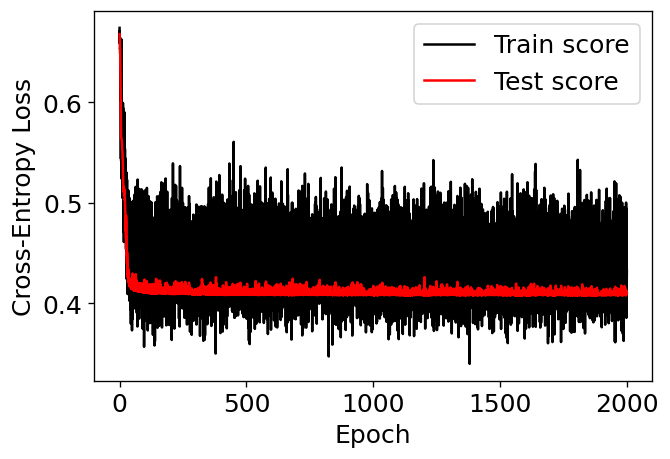

250 0.8937381404174574 0.6755345410352815
500 0.8994307400379506 0.6831681288215411
750 0.9070208728652751 0.6884280885648095
1000 0.8975332068311196 0.6806235995594546
1250 0.9070208728652751 0.6933462458698871
1500 0.9013282732447818 0.6857126580836277
1750 0.9032258064516129 0.6882571873457142
---------------------------------------------
ARCH = VDFCNN_4040_CNN3_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 91.6+/-6.621178142898739
TN = 377.2+/-5.706137047074842
FP = 14.0+/-6.54217089351845
FN = 44.2+/-6.49307323229917
Acc = 0.8895635673624287+/-0.020486329527538153
TSS = 0.6388345654037689+/-0.057248306413644104
=>=>=> NUMBER OF EPOCHS: 500
TP = 99.8+/-7.833262411026456
TN = 378.4+/-4.715930449020639
FP = 12.8+/-5.192301994298868
FN = 36.0+/-8.78635305459552
Acc = 0.9074003795066414+/-0.011090428232411739
TSS = 0.7027696126996574+/-0.05223995987720622
=>=>=> NUMBER OF EPOCHS: 750
TP = 98.2+/-11.565465835840769
TN = 384.4+/-4.923413450036469
FP = 6.8+/-5.035871324805669
FN = 37.6+/-12.611

In [14]:
# NETWORK: VDFCNN_4040_CNN3_CONN2
ARCH = 'VDFCNN_4040_CNN3_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:19<00:00, 25.23it/s]


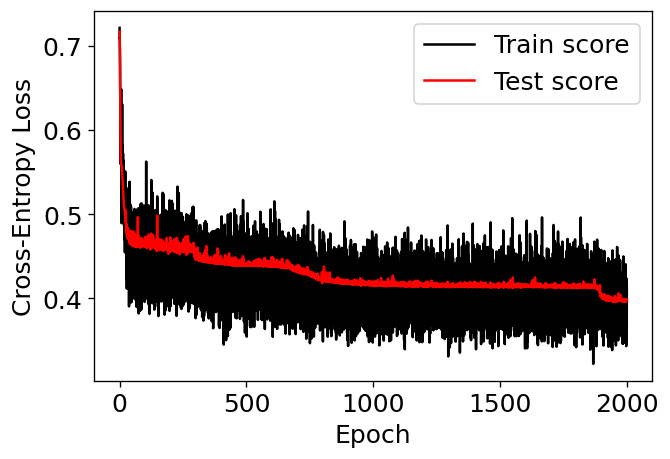

250 0.857685009487666 0.5606083737261937
500 0.8766603415559773 0.6308156177245143
750 0.8823529411764706 0.6732949124079234
1000 0.8994307400379506 0.7210411816342888
1250 0.9013282732447818 0.72855997862677
1500 0.8994307400379506 0.7260219075607801
1750 0.8937381404174574 0.723388420289302
---------------------------------------------


100%|██████████| 2000/2000 [01:19<00:00, 25.21it/s]


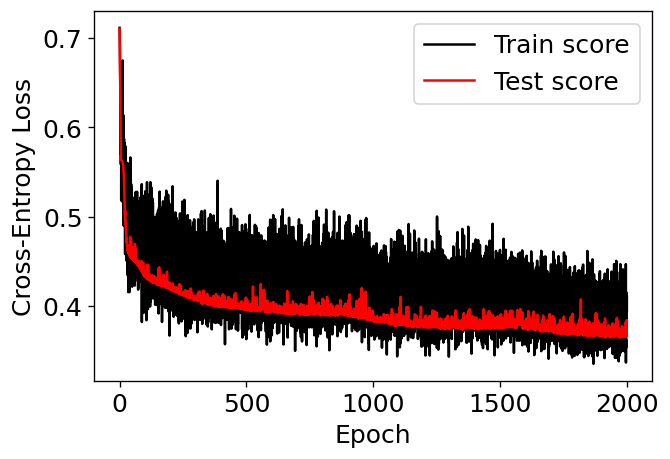

250 0.9013282732447818 0.6787527193618564
500 0.920303605313093 0.7539406892866685
750 0.905123339658444 0.6888095874203274
1000 0.9278937381404174 0.7740544254036106
1250 0.9335863377609108 0.8065722682340368
1500 0.9430740037950665 0.819262623563986
1750 0.937381404174573 0.8216098622189992
---------------------------------------------


100%|██████████| 2000/2000 [01:19<00:00, 25.23it/s]


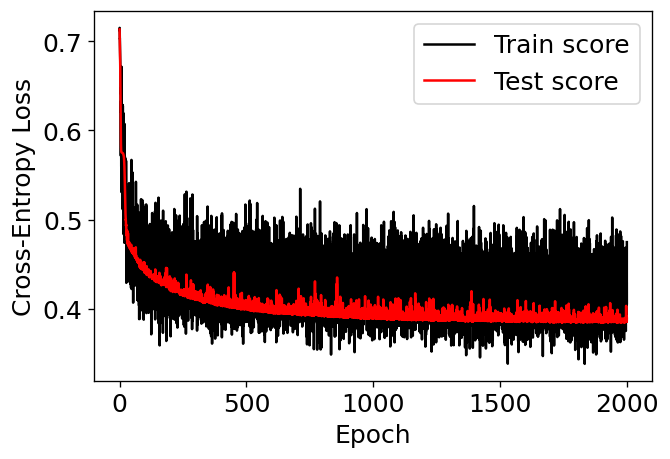

250 0.889943074003795 0.7397092635170214
500 0.9165085388994307 0.7665578877104502
750 0.9316888045540797 0.8241118445449827
1000 0.9316888045540797 0.8333456945783579
1250 0.9278937381404174 0.8281910554031002
1500 0.9259962049335864 0.816379885782096
1750 0.9259962049335864 0.8025291107320329
---------------------------------------------


100%|██████████| 2000/2000 [01:19<00:00, 25.13it/s]


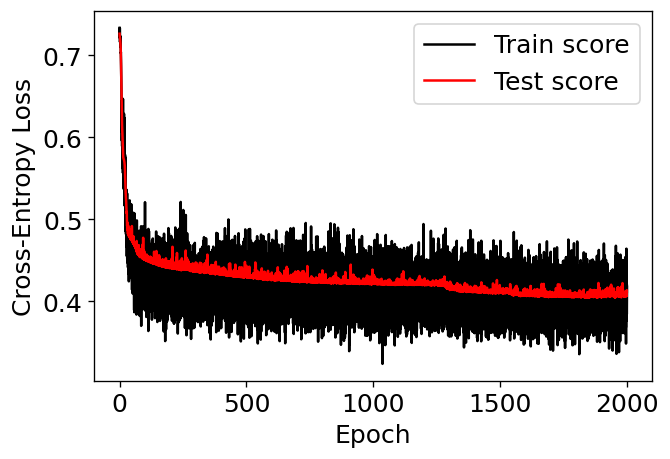

250 0.8633776091081594 0.5723329641934293
500 0.8671726755218216 0.5866186784791435
750 0.8937381404174574 0.6957364341085271
1000 0.8937381404174574 0.6866186784791436
1250 0.8956356736242884 0.6983204134366925
1500 0.8956356736242884 0.7211148025101514
1750 0.905123339658444 0.7522702104097453
---------------------------------------------


100%|██████████| 2000/2000 [01:19<00:00, 25.16it/s]


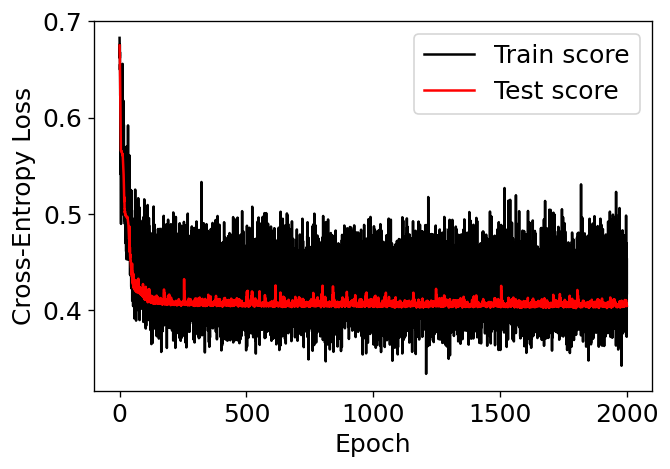

250 0.905123339658444 0.67112908738749
500 0.905123339658444 0.67112908738749
750 0.9032258064516129 0.6489119289050929
1000 0.9089184060721063 0.690972617826896
1250 0.9108159392789373 0.6787626751737496
1500 0.905123339658444 0.6662109300824124
1750 0.9108159392789373 0.6836808324788273
---------------------------------------------
ARCH = VDFCNN_4040_CNN3_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 94.6+/-11.056219968868202
TN = 371.0+/-10.507140429250958
FP = 20.2+/-8.704022058795578
FN = 41.2+/-10.225458424931373
Acc = 0.8834914611005692+/-0.019484626418206363
TSS = 0.6445064816371981+/-0.06810733696767045
=>=>=> NUMBER OF EPOCHS: 500
TP = 98.4+/-9.112628599915615
TN = 374.4+/-6.374950980203691
FP = 16.8+/-5.035871324805669
FN = 37.4+/-9.264987857520376
Acc = 0.8971537001897533+/-0.02141439996913226
TSS = 0.6818123921176532+/-0.06951393729393174
=>=>=> NUMBER OF EPOCHS: 750
TP = 102.0+/-10.807404868885037
TN = 374.0+/-8.508818954473059
FP = 17.2+/-7.413501197140255
FN = 33.8+/-8.795453

In [15]:
# NETWORK: VDFCNN_4040_CNN3_CONN1
ARCH = 'VDFCNN_4040_CNN3_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN3_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:16<00:00, 26.21it/s]


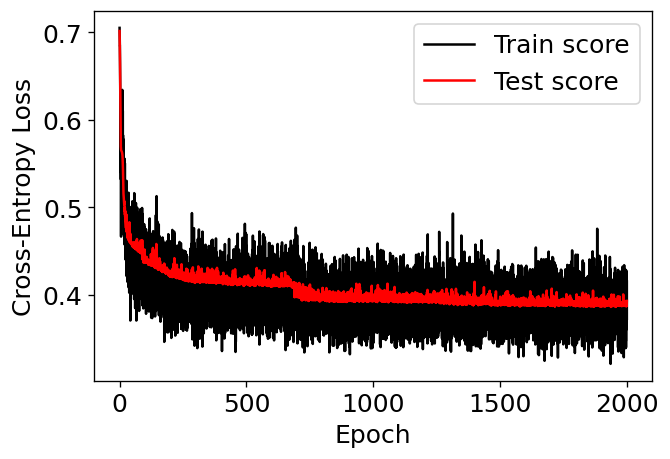

250 0.8956356736242884 0.7458493950612571
500 0.8994307400379506 0.7459448112667455
750 0.9127134724857685 0.743788405022709
1000 0.920303605313093 0.7838250448456165
1250 0.9222011385199241 0.7863631159116065
1500 0.9184060721062619 0.7763062478531353
1750 0.9278937381404174 0.793977329109576
---------------------------------------------


100%|██████████| 2000/2000 [01:16<00:00, 26.22it/s]


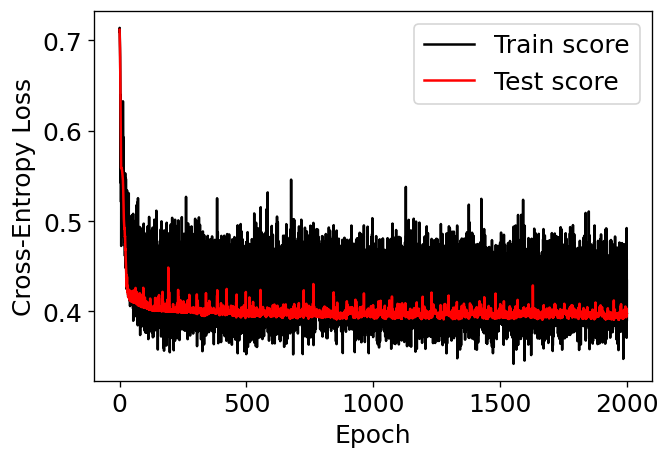

250 0.9108159392789373 0.6765008969123315
500 0.9146110056925996 0.6965192168237854
750 0.9127134724857685 0.6790389679783214
1000 0.9089184060721063 0.6938857295523071
1250 0.9184060721062619 0.6966146330292736
1500 0.9127134724857685 0.6890004198313041
1750 0.9184060721062619 0.6966146330292736
---------------------------------------------


100%|██████████| 2000/2000 [01:16<00:00, 26.25it/s]


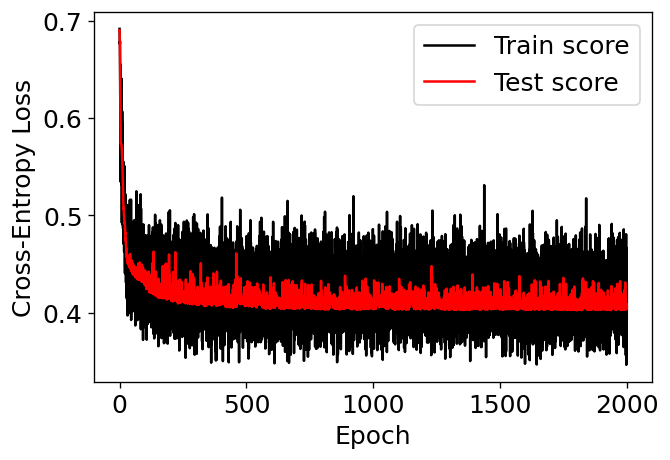

250 0.905123339658444 0.6679893198842988
500 0.9013282732447818 0.676685455759104
750 0.9070208728652751 0.6751835644886153
1000 0.905123339658444 0.6679893198842988
1250 0.9013282732447818 0.6536008306756655
1500 0.9127134724857685 0.6782985982348142
1750 0.8804554079696395 0.6483349402951865
---------------------------------------------


100%|██████████| 2000/2000 [01:16<00:00, 26.09it/s]


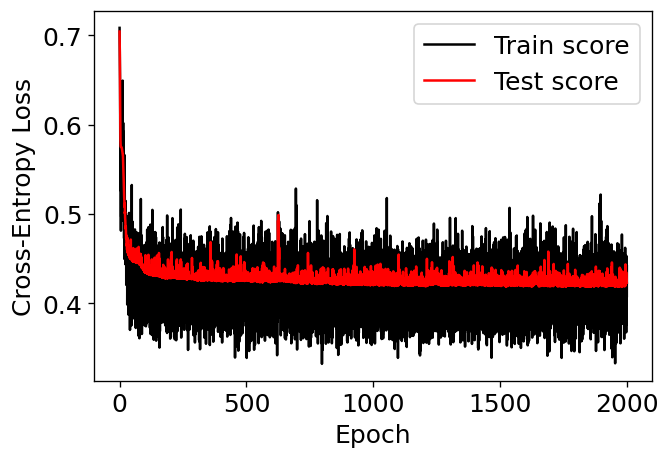

250 0.8804554079696395 0.5864710225175341
500 0.889943074003795 0.62218530823182
750 0.8918406072106262 0.6293281653746771
1000 0.8823529411764706 0.6164082687338501
1250 0.8709677419354839 0.6009043927648579
1500 0.8918406072106262 0.6293281653746771
1750 0.8937381404174574 0.6319121447028424
---------------------------------------------


100%|██████████| 2000/2000 [01:16<00:00, 26.07it/s]


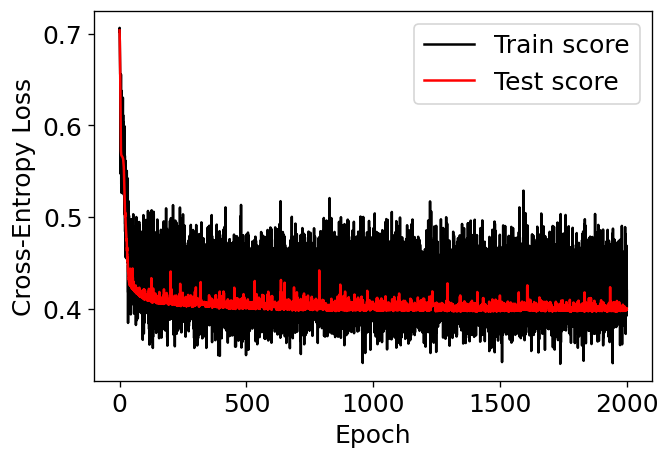

250 0.9013282732447818 0.6857126580836277
500 0.9108159392789373 0.6738445178686719
750 0.9127134724857685 0.6763890471307584
1000 0.9070208728652751 0.6736736166495766
1250 0.9070208728652751 0.6835099312597319
1500 0.9089184060721063 0.6860544605218184
1750 0.9146110056925996 0.6986062056131556
---------------------------------------------
ARCH = VDFCNN_4040_CNN2_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 95.8+/-8.182909018191513
TN = 377.8+/-8.634813257969162
FP = 13.4+/-9.871170143402454
FN = 40.0+/-10.392304845413264
Acc = 0.8986717267552182+/-0.010365465111003901
TSS = 0.6725046584918097+/-0.050974594375762135
=>=>=> NUMBER OF EPOCHS: 500
TP = 96.8+/-6.675327707311453
TN = 379.2+/-8.304215796810679
FP = 12.0+/-8.717797887081348
FN = 39.0+/-8.48528137423857
Acc = 0.903225806451613+/-0.008736899000547497
TSS = 0.6830358619900254+/-0.03991725219853976
=>=>=> NUMBER OF EPOCHS: 750
TP = 95.2+/-5.192301994298868
TN = 383.0+/-5.253570214625479
FP = 8.2+/-5.075431016179809
FN = 40.6+/-6.887

In [16]:
# NETWORK: VDFCNN_4040_CNN2_CONN2
ARCH = 'VDFCNN_4040_CNN2_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN2_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:11<00:00, 27.93it/s]


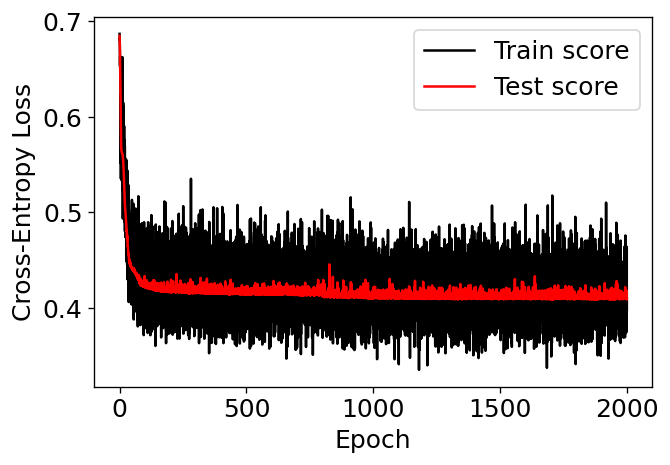

250 0.9013282732447818 0.6438876378764169
500 0.8956356736242884 0.6412541506049387
750 0.905123339658444 0.653944505934888
1000 0.8937381404174574 0.6486775313919316
1250 0.9070208728652751 0.6664440288538606
1500 0.905123339658444 0.6489637800083966
1750 0.905123339658444 0.6489637800083966
---------------------------------------------


100%|██████████| 2000/2000 [01:12<00:00, 27.74it/s]


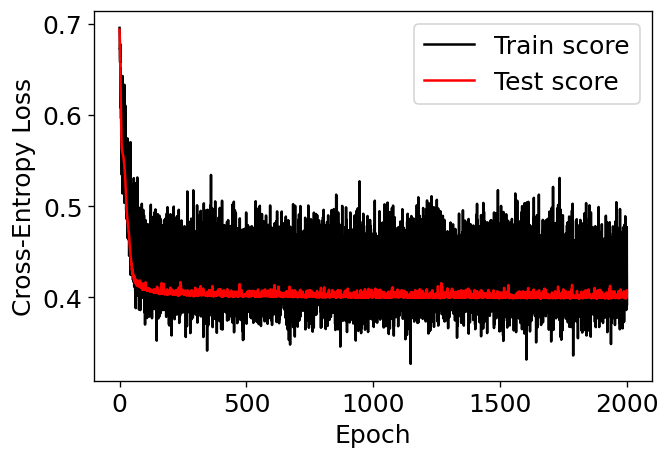

250 0.9070208728652751 0.6614633029273691
500 0.9165085388994307 0.6990572878897752
750 0.9127134724857685 0.6939811457577956
1000 0.9127134724857685 0.6840196939048128
1250 0.9127134724857685 0.6939811457577956
1500 0.9127134724857685 0.6939811457577956
1750 0.9146110056925996 0.6965192168237854
---------------------------------------------


100%|██████████| 2000/2000 [01:12<00:00, 27.67it/s]


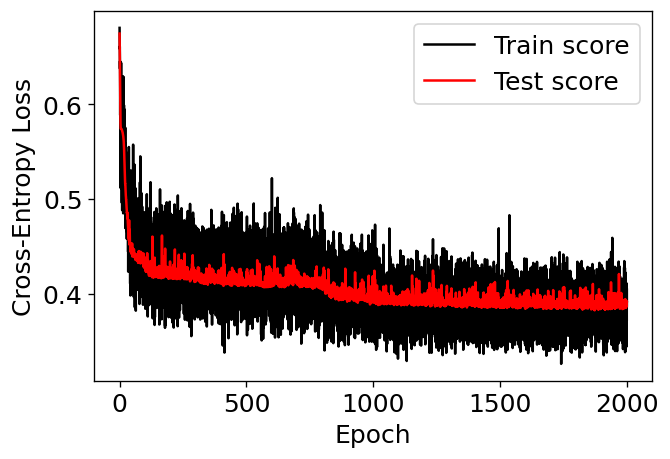

250 0.8956356736242884 0.632018096862716
500 0.8975332068311196 0.6853815916339094
750 0.9013282732447818 0.6813023807757917
1000 0.9240986717267552 0.7491656159608395
1250 0.9259962049335864 0.7563598605651561
1500 0.9316888045540797 0.773325669361418
1750 0.9089184060721063 0.7470147593265594
---------------------------------------------


100%|██████████| 2000/2000 [01:12<00:00, 27.75it/s]


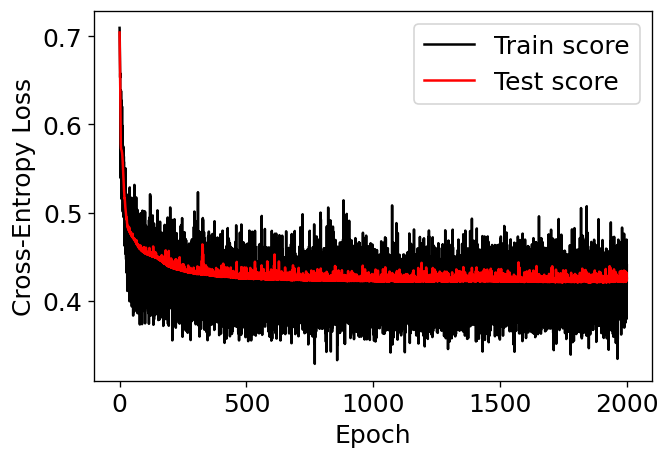

250 0.8861480075901328 0.6033407161314138
500 0.889943074003795 0.6267441860465116
750 0.8918406072106262 0.6293281653746771
1000 0.889943074003795 0.6267441860465116
1250 0.889943074003795 0.6176264304171281
1500 0.8937381404174574 0.6319121447028424
1750 0.889943074003795 0.6176264304171281
---------------------------------------------


100%|██████████| 2000/2000 [01:12<00:00, 27.52it/s]


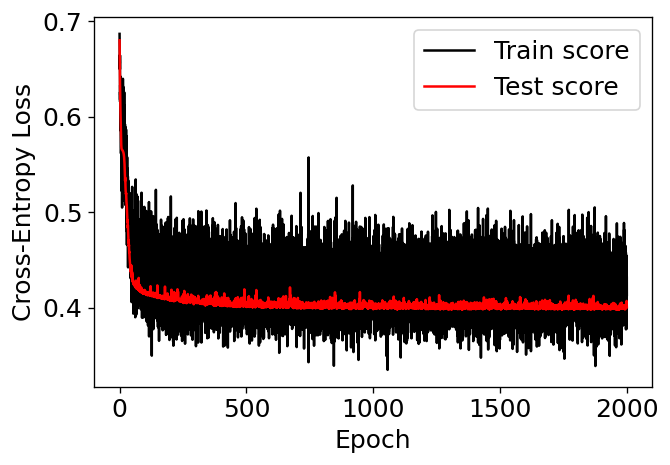

250 0.9032258064516129 0.6685845581254035
500 0.9146110056925996 0.6986062056131556
750 0.9165085388994307 0.6962325775701645
1000 0.9184060721062619 0.7086134214424062
1250 0.9108159392789373 0.6935171470889825
1500 0.9146110056925996 0.6838517336979226
1750 0.9108159392789373 0.6787626751737496
---------------------------------------------
ARCH = VDFCNN_4040_CNN2_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 89.6+/-2.0591260281974
TN = 384.0+/-3.03315017762062
FP = 7.2+/-1.469693845669907
FN = 46.2+/-4.308131845707603
Acc = 0.8986717267552182+/-0.007260389552071728
TSS = 0.6418588623846638+/-0.023165496276400854
=>=>=> NUMBER OF EPOCHS: 500
TP = 94.4+/-4.17612260356422
TN = 381.4+/-5.782732917920384
FP = 9.8+/-3.54400902933387
FN = 41.4+/-4.454211490264018
Acc = 0.9028462998102466+/-0.010693740268391169
TSS = 0.6702086843576581+/-0.03031965003986837
=>=>=> NUMBER OF EPOCHS: 750
TP = 93.8+/-3.4871191548325386
TN = 383.4+/-4.963869458396343
FP = 7.8+/-2.4
FN = 42.0+/-4.049691346263317
Acc = 

In [17]:
# NETWORK: VDFCNN_4040_CNN2_CONN1
ARCH = 'VDFCNN_4040_CNN2_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN2_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:06<00:00, 30.11it/s]


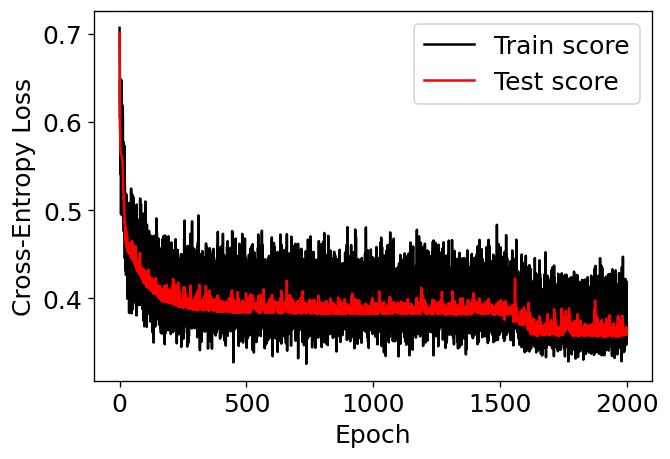

250 0.9259962049335864 0.7366512728521811
500 0.9316888045540797 0.7492462119766421
750 0.920303605313093 0.748959963360177
1000 0.920303605313093 0.7539406892866685
1250 0.9278937381404174 0.7541315216976452
1500 0.9240986717267552 0.7590168314186482
1750 0.9506641366223909 0.8343956337544368
---------------------------------------------


100%|██████████| 2000/2000 [01:07<00:00, 29.75it/s]


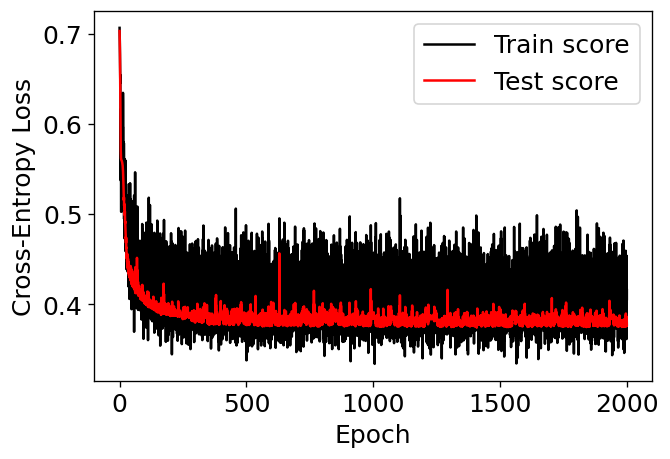

250 0.9278937381404174 0.7690736994771191
500 0.9316888045540797 0.7691691156826076
750 0.937381404174573 0.7668218770275944
1000 0.9278937381404174 0.7541315216976452
1250 0.9297912713472486 0.7765924964696004
1500 0.9335863377609108 0.7766879126750887
1750 0.9335863377609108 0.7766879126750887
---------------------------------------------


100%|██████████| 2000/2000 [01:06<00:00, 30.03it/s]


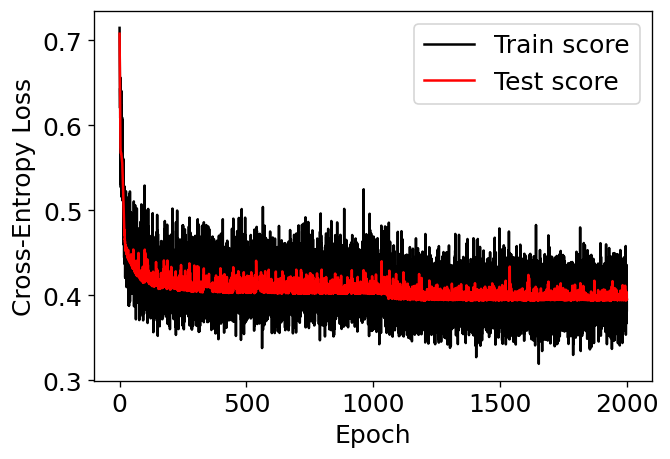

250 0.9032258064516129 0.6654120002966698
500 0.9108159392789373 0.6803382036638731
750 0.9108159392789373 0.6711043536304977
1000 0.9127134724857685 0.696766298301565
1250 0.920303605313093 0.7116925016687681
1500 0.9127134724857685 0.7013832233182525
1750 0.9222011385199241 0.7235036712897723
---------------------------------------------


100%|██████████| 2000/2000 [01:06<00:00, 30.01it/s]


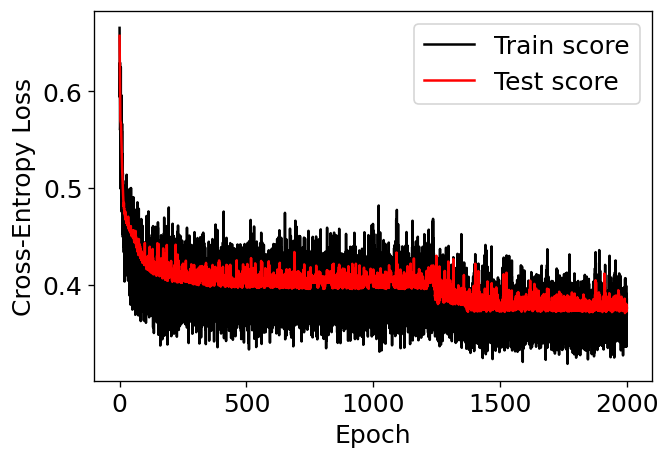

250 0.8956356736242884 0.7119970468807678
500 0.9184060721062619 0.7247692875599853
750 0.9184060721062619 0.7247692875599853
1000 0.9108159392789373 0.7235511258767072
1250 0.9013282732447818 0.6513658176448874
1500 0.9392789373814042 0.8124584717607973
1750 0.9240986717267552 0.7917866371354744
---------------------------------------------


100%|██████████| 2000/2000 [01:06<00:00, 29.94it/s]


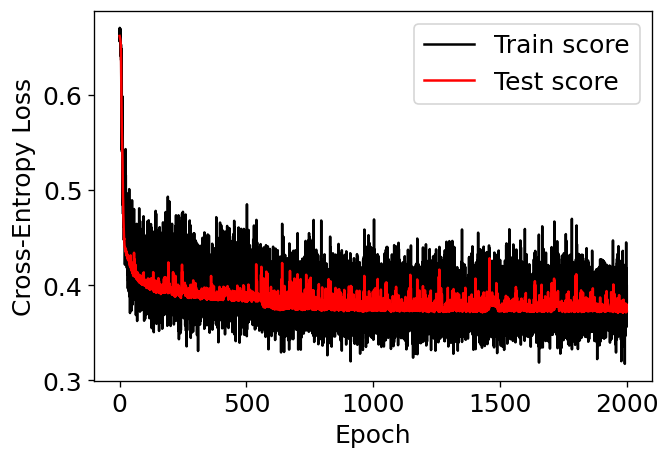

250 0.9165085388994307 0.730659678705708
500 0.9278937381404174 0.7557631688883826
750 0.9222011385199241 0.718620637271657
1000 0.937381404174573 0.7930766017242035
1250 0.9392789373814042 0.79562113098629
1500 0.9392789373814042 0.7857848163761346
1750 0.9392789373814042 0.8103756029015229
---------------------------------------------
ARCH = VDFCNN_4040_CNN1_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 102.2+/-4.578209256903839
TN = 379.4+/-8.114185110040317
FP = 11.8+/-6.046486583132389
FN = 33.6+/-5.607138307550474
Acc = 0.9138519924098671+/-0.012621092332687586
TSS = 0.7227587396424893+/-0.03407334843023653
=>=>=> NUMBER OF EPOCHS: 500
TP = 102.0+/-3.286335345030997
TN = 385.0+/-3.22490309931942
FP = 6.2+/-1.8330302779823362
FN = 33.8+/-5.30659966456864
Acc = 0.9240986717267552+/-0.008227507927392323
TSS = 0.7358571975542981+/-0.031274583041151334
=>=>=> NUMBER OF EPOCHS: 750
TP = 100.6+/-3.97994974842648
TN = 385.2+/-4.166533331199931
FP = 6.0+/-3.8987177379235853
FN = 35.2+/-5.706137

In [18]:
# NETWORK: VDFCNN_4040_CNN1_CONN2
ARCH = 'VDFCNN_4040_CNN1_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN1_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:03<00:00, 31.72it/s]


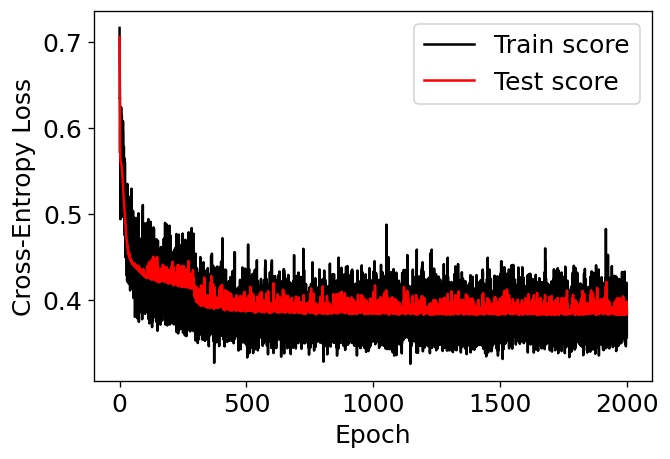

250 0.8785578747628083 0.6482958665699783
500 0.9297912713472486 0.756669592763635
750 0.9316888045540797 0.7592076638296248
1000 0.9278937381404174 0.7342086179916797
1250 0.9146110056925996 0.7513072020151902
1500 0.9165085388994307 0.7389030953017061
1750 0.9316888045540797 0.7641883897561161
---------------------------------------------


100%|██████████| 2000/2000 [01:09<00:00, 28.80it/s]


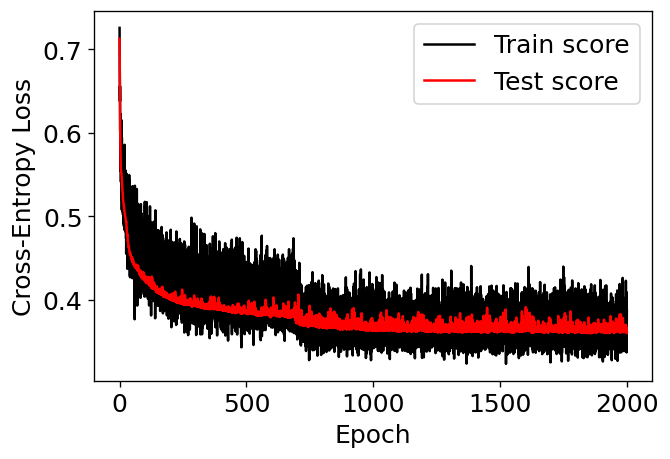

250 0.9184060721062619 0.7165375367352391
500 0.9335863377609108 0.7766879126750887
750 0.9449715370018975 0.7968970649975192
1000 0.9430740037950665 0.8541277050494256
1250 0.9506641366223909 0.8742414411663677
1500 0.9544592030360531 0.8643754055188733
1750 0.9487666034155597 0.8617419182473951
---------------------------------------------


100%|██████████| 2000/2000 [01:05<00:00, 30.46it/s]


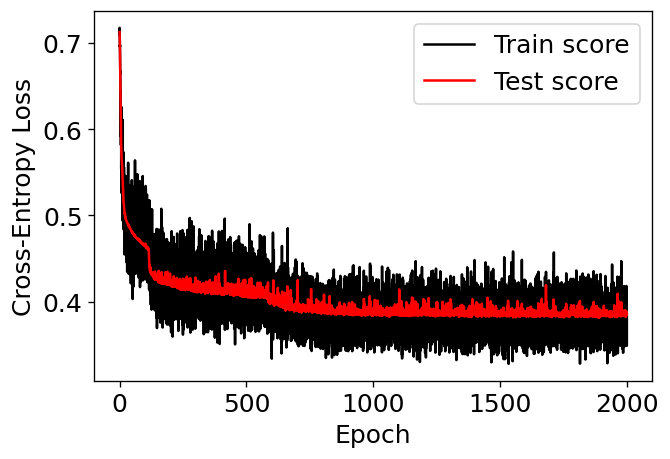

250 0.8994307400379506 0.6787250611881629
500 0.9070208728652751 0.707502039605429
750 0.937381404174573 0.7810576281243047
1000 0.9259962049335864 0.7609767855818438
1250 0.9316888045540797 0.773325669361418
1500 0.9354838709677419 0.7877141585700511
1750 0.9354838709677419 0.7969480086034265
---------------------------------------------


100%|██████████| 2000/2000 [01:05<00:00, 30.76it/s]


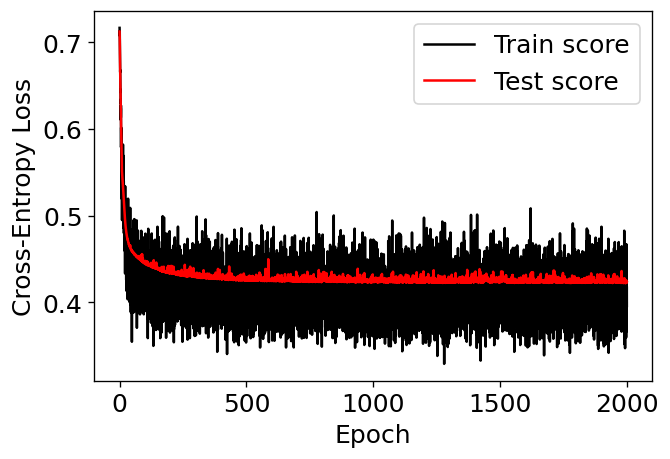

250 0.889943074003795 0.62218530823182
500 0.888045540796964 0.628719084533038
750 0.8918406072106262 0.6384459210040605
1000 0.889943074003795 0.6176264304171281
1250 0.9013282732447818 0.6468069398301957
1500 0.9013282732447818 0.6513658176448874
1750 0.8937381404174574 0.6364710225175342
---------------------------------------------


100%|██████████| 2000/2000 [01:05<00:00, 30.62it/s]


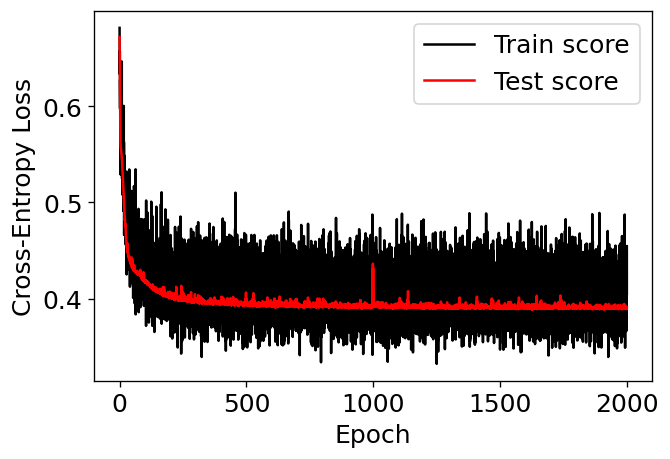

250 0.9070208728652751 0.6589191447343437
500 0.920303605313093 0.7259124226197259
750 0.9184060721062619 0.7233678933576393
1000 0.9184060721062619 0.7577949944931829
1250 0.9259962049335864 0.7483004823212184
1500 0.9297912713472486 0.7484713835403137
1750 0.9297912713472486 0.7484713835403137
---------------------------------------------
ARCH = VDFCNN_4040_CNN1_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 94.4+/-3.826225293941798
TN = 379.2+/-7.30479294709987
FP = 12.0+/-7.4565407529228995
FN = 41.4+/-5.2
Acc = 0.8986717267552182+/-0.013714847058514366
TSS = 0.6649325834919088+/-0.031602452366995874
=>=>=> NUMBER OF EPOCHS: 500
TP = 100.8+/-4.791659420284375
TN = 381.8+/-5.192301994298868
FP = 9.4+/-2.244994432064365
FN = 35.0+/-7.211102550927978
Acc = 0.9157495256166983+/-0.016611816795627548
TSS = 0.7190982104393834+/-0.05114190774422929
=>=>=> NUMBER OF EPOCHS: 750
TP = 102.6+/-5.885575587824865
TN = 384.8+/-4.707440918375927
FP = 6.4+/-2.727636339397171
FN = 33.2+/-7.359347797189639


In [19]:
# NETWORK: VDFCNN_4040_CNN1_CONN1
ARCH = 'VDFCNN_4040_CNN1_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN1_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

## Best Network Architecture

CONCLUSION:

Best network configuration: VDFCNN_4040_CNN1_CONN2 with 1750 epochs

Running for the best configuration now...

In [ ]:
# NETWORK: VDFCNN_4040_CNN1_CONN2
ARCH = 'VDFCNN_4040_CNN1_CONN2'

tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN1_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 1750
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = -1

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

# Best architecture for 60x60 VDFs (5-fold CV for faster assessment)

In [20]:
class VDFCNN_6060_CNN3_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN3_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*7*7+12, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 16 * 7 * 7)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN3_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN3_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*7*7+12, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 16 * 7 * 7)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN2_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN2_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*15*15+12, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 8 * 15 * 15)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN2_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN2_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*15*15+12, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 8 * 15 * 15)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN1_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN1_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(4*30*30+12, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 4 * 30 * 30)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN1_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN1_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(4*30*30+12, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 4 * 30 * 30)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x

100%|██████████| 2000/2000 [02:12<00:00, 15.12it/s]


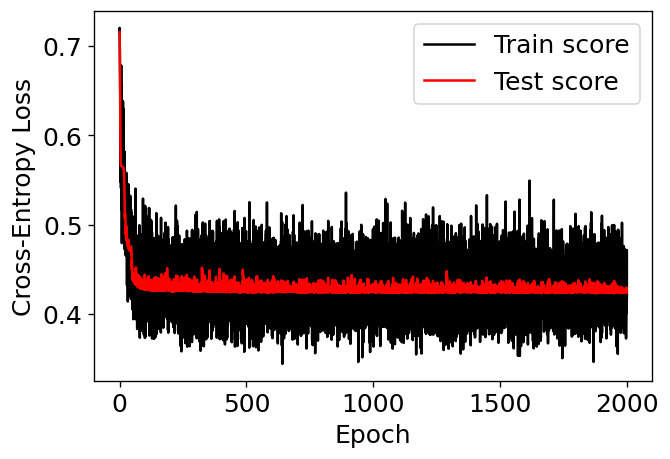

RERUNNING THE SAMPLE...


100%|██████████| 2000/2000 [02:12<00:00, 15.10it/s]


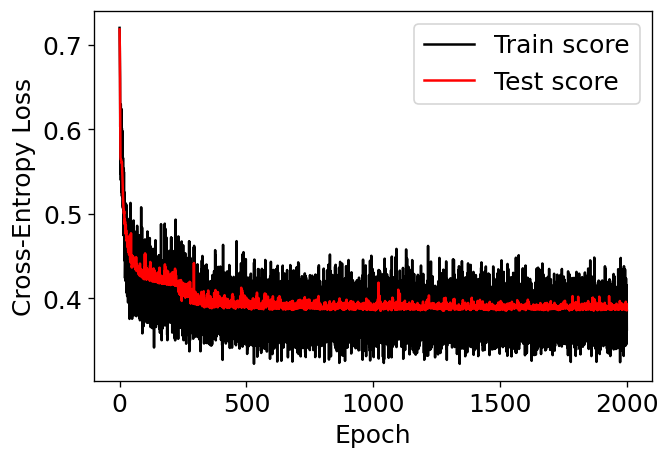

250 0.9032258064516129 0.7310980496927598
500 0.9165085388994307 0.7638067249341628
750 0.920303605313093 0.7937864966985992
1000 0.9240986717267552 0.8038433647570703
1250 0.9240986717267552 0.798862638830579
1500 0.9278937381404174 0.8039387809625587
1750 0.9222011385199241 0.781382389985115
---------------------------------------------


100%|██████████| 2000/2000 [02:11<00:00, 15.17it/s]


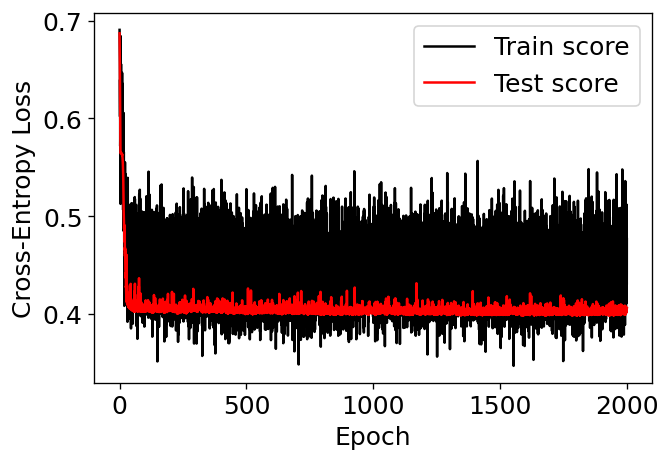

250 0.9089184060721063 0.6839242776993244
500 0.905123339658444 0.6888095874203274
750 0.905123339658444 0.6838288614938361
1000 0.9127134724857685 0.6890004198313041
1250 0.9070208728652751 0.6913476584863173
1500 0.9165085388994307 0.6940765619632838
1750 0.9165085388994307 0.6940765619632838
---------------------------------------------


100%|██████████| 2000/2000 [02:11<00:00, 15.20it/s]


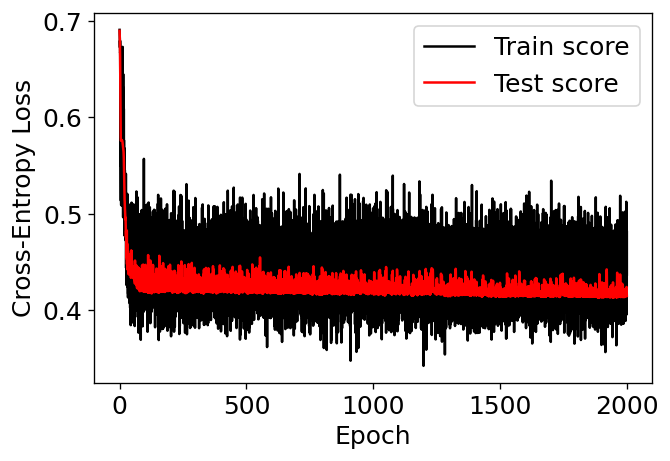

250 0.8975332068311196 0.662296966550471
500 0.8956356736242884 0.6597196469628421
750 0.8975332068311196 0.6530631165170956
1000 0.8937381404174574 0.6663761774085886
1250 0.9013282732447818 0.662834680709041
1500 0.8918406072106262 0.6637988578209597
1750 0.8994307400379506 0.6741081361714751
---------------------------------------------


100%|██████████| 2000/2000 [02:11<00:00, 15.22it/s]


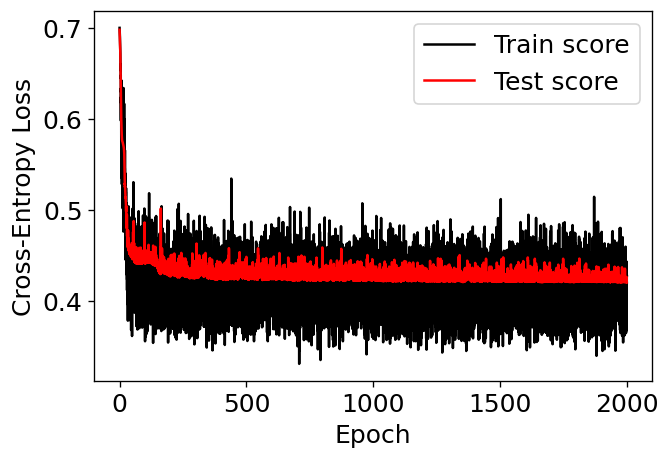

250 0.8785578747628083 0.6066814322628277
500 0.8633776091081594 0.5905684754521964
750 0.8956356736242884 0.6299372462163161
1000 0.889943074003795 0.6176264304171281
1250 0.8975332068311196 0.6325212255444814
1500 0.8918406072106262 0.6247692875599853
1750 0.8842504743833017 0.6053156146179401
---------------------------------------------


100%|██████████| 2000/2000 [02:13<00:00, 14.93it/s]


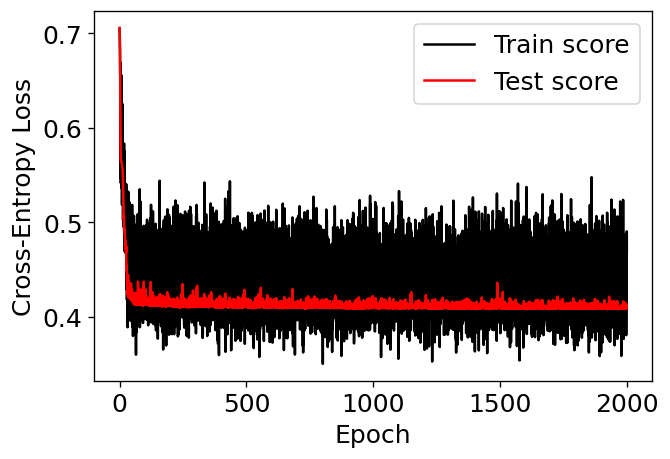

250 0.9013282732447818 0.6857126580836277
500 0.9013282732447818 0.6857126580836277
750 0.905123339658444 0.6908017166078007
1000 0.8994307400379506 0.6585773422961528
1250 0.9013282732447818 0.6857126580836277
1500 0.8975332068311196 0.6806235995594546
1750 0.9070208728652751 0.6933462458698871
---------------------------------------------
ARCH = VDFCNN_6060_CNN3_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 96.4+/-4.923413450036469
TN = 376.8+/-4.833218389437828
FP = 14.4+/-4.8
FN = 39.4+/-7.227724399837061
Acc = 0.8979127134724857+/-0.01035156106033083
TSS = 0.6739426768578021+/-0.04040940249582031
=>=>=> NUMBER OF EPOCHS: 500
TP = 97.6+/-5.607138307550475
TN = 374.8+/-5.775811631277461
FP = 16.4+/-4.079215610874228
FN = 38.2+/-7.959899496852959
Acc = 0.896394686907021+/-0.017865050923627807
TSS = 0.6777234185706312+/-0.0557085031648144
=>=>=> NUMBER OF EPOCHS: 750
TP = 97.8+/-7.934733769950949
TN = 379.0+/-3.687817782917155
FP = 12.2+/-5.635601121442149
FN = 38.0+/-10.178408519999577
Acc

In [21]:
# NETWORK: VDFCNN_6060_CNN3_CONN2
ARCH = 'VDFCNN_6060_CNN3_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [02:06<00:00, 15.81it/s]


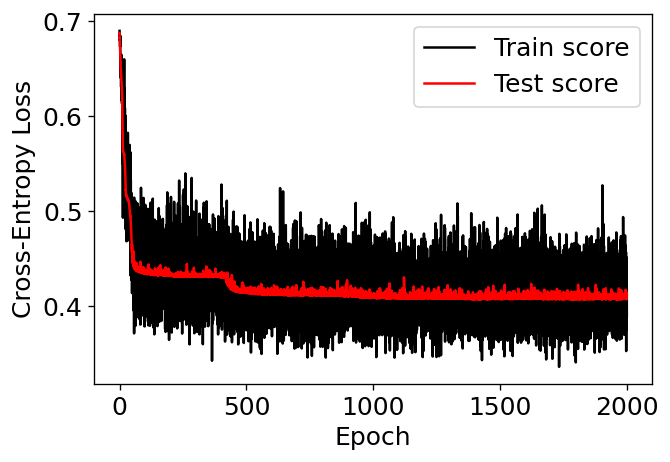

250 0.8785578747628083 0.6233922369375214
500 0.8956356736242884 0.6462348765314301
750 0.8956356736242884 0.6462348765314301
1000 0.9013282732447818 0.6538490897293996
1250 0.905123339658444 0.653944505934888
1500 0.905123339658444 0.6589252318613793
1750 0.9070208728652751 0.6564825770008779
---------------------------------------------


100%|██████████| 2000/2000 [02:08<00:00, 15.59it/s]


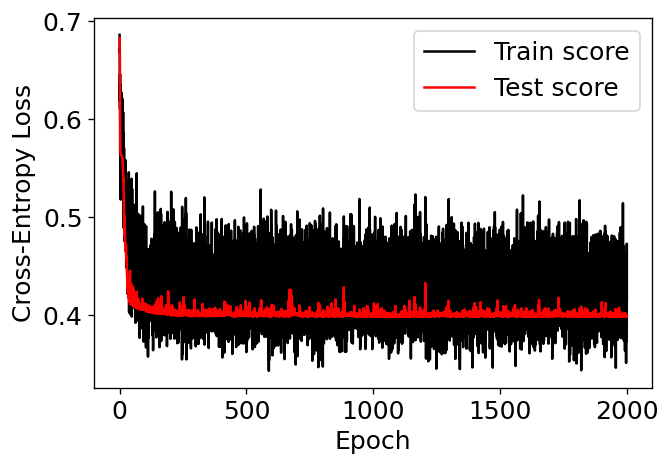

250 0.9070208728652751 0.6515018510743864
500 0.9127134724857685 0.6840196939048128
750 0.9108159392789373 0.681481622838823
1000 0.9127134724857685 0.6740582420518301
1250 0.9127134724857685 0.6790389679783214
1500 0.9127134724857685 0.6840196939048128
1750 0.9127134724857685 0.6840196939048128
---------------------------------------------


100%|██████████| 2000/2000 [02:12<00:00, 15.14it/s]


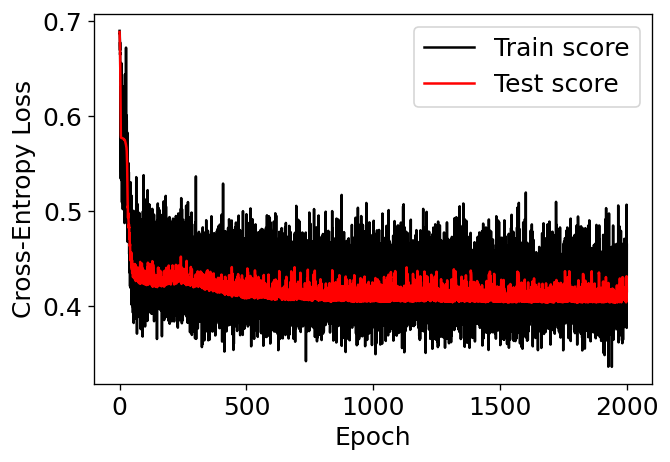

250 0.8785578747628083 0.6319068456574946
500 0.8975332068311196 0.6392123414670325
750 0.9070208728652751 0.6751835644886153
1000 0.9089184060721063 0.6869947341096194
1250 0.8804554079696395 0.6483349402951865
1500 0.905123339658444 0.6726062449009864
1750 0.8918406072106262 0.6637988578209597
---------------------------------------------


100%|██████████| 2000/2000 [02:07<00:00, 15.72it/s]


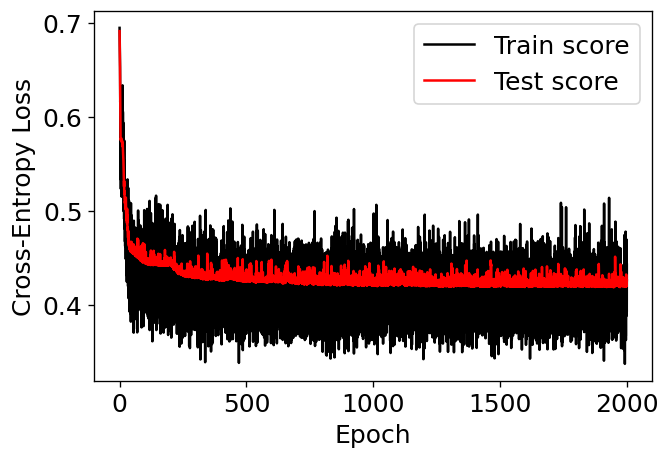

250 0.8842504743833017 0.5961978589885567
500 0.889943074003795 0.6176264304171281
750 0.889943074003795 0.6267441860465116
1000 0.8994307400379506 0.6396640826873385
1250 0.8994307400379506 0.6396640826873385
1500 0.8956356736242884 0.6253783684016242
1750 0.8937381404174574 0.6273532668881506
---------------------------------------------


100%|██████████| 2000/2000 [02:09<00:00, 15.49it/s]


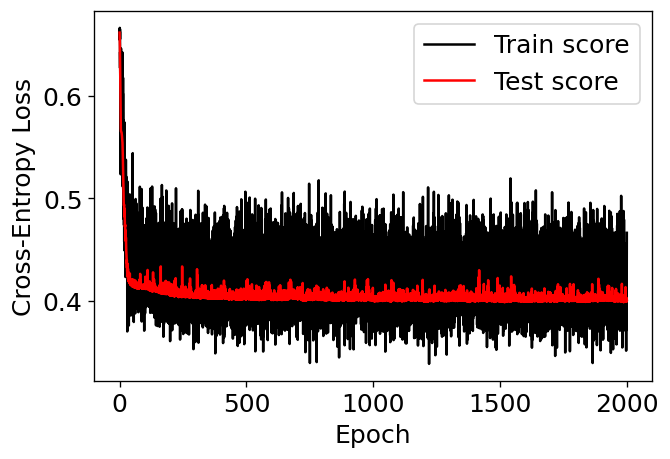

250 0.9089184060721063 0.6663818313015077
500 0.9070208728652751 0.6441646728191105
750 0.9146110056925996 0.6986062056131556
1000 0.9146110056925996 0.6838517336979226
1250 0.9127134724857685 0.6911435190459915
1500 0.9108159392789373 0.6738445178686719
1750 0.9146110056925996 0.6838517336979226
---------------------------------------------
ARCH = VDFCNN_6060_CNN3_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 90.0+/-3.03315017762062
TN = 379.8+/-8.447484832777151
FP = 11.4+/-7.4993333037010705
FN = 45.8+/-4.166533331199932
Acc = 0.8914611005692599+/-0.013651693167821593
TSS = 0.6338761247918934+/-0.024086215399990372
=>=>=> NUMBER OF EPOCHS: 500
TP = 90.0+/-2.0
TN = 384.6+/-4.17612260356422
FP = 6.6+/-3.2
FN = 45.8+/-3.867815921162743
Acc = 0.9005692599620494+/-0.00819242244589105
TSS = 0.6462516030279029+/-0.021446379443988105
=>=>=> NUMBER OF EPOCHS: 750
TP = 93.2+/-2.481934729198171
TN = 383.0+/-3.22490309931942
FP = 8.2+/-2.1354156504062622
FN = 42.6+/-3.7202150475476548
Acc = 0.9036053

In [22]:
# NETWORK: VDFCNN_6060_CNN3_CONN1
ARCH = 'VDFCNN_6060_CNN3_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN3_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [02:00<00:00, 16.56it/s]


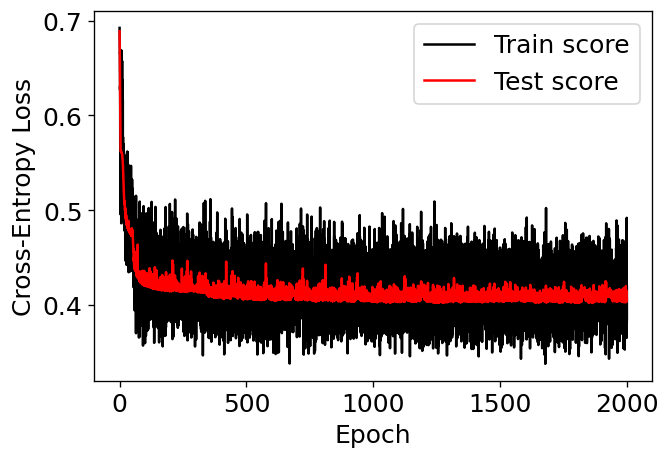

250 0.8975332068311196 0.633830769817946
500 0.8994307400379506 0.6612724705163925
750 0.9032258064516129 0.6663486126483722
1000 0.8994307400379506 0.6513110186634098
1250 0.9070208728652751 0.6714247547803519
1500 0.9032258064516129 0.6713293385748635
1750 0.905123339658444 0.668886683714362
---------------------------------------------


100%|██████████| 2000/2000 [01:58<00:00, 16.86it/s]


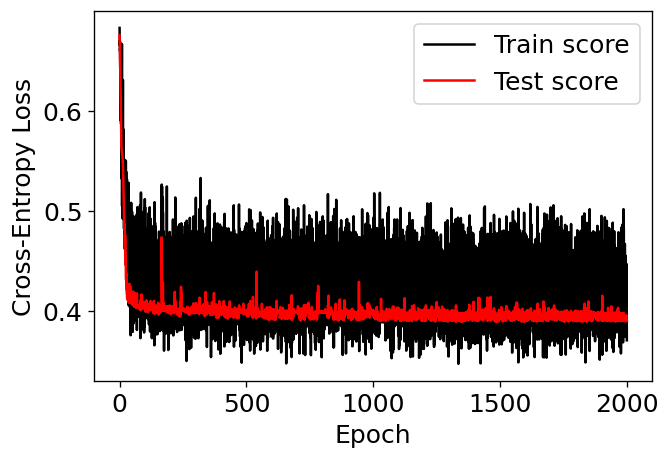

250 0.9108159392789373 0.6765008969123315
500 0.9165085388994307 0.7040380138162665
750 0.9222011385199241 0.6917293233082706
1000 0.9165085388994307 0.6990572878897752
1250 0.9146110056925996 0.6616541353383458
1500 0.9184060721062619 0.6816724552497997
1750 0.9297912713472486 0.7218045112781954
---------------------------------------------


100%|██████████| 2000/2000 [02:01<00:00, 16.42it/s]


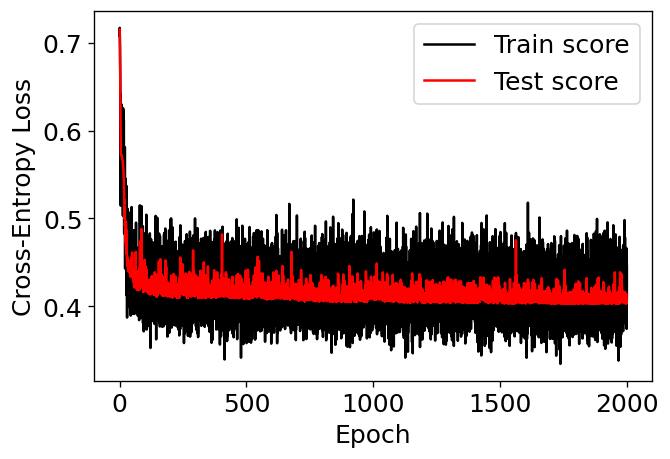

250 0.8804554079696395 0.6483349402951865
500 0.8823529411764706 0.6555291848995031
750 0.889943074003795 0.6658384632500185
1000 0.9070208728652751 0.6798004895053029
1250 0.9013282732447818 0.6536008306756655
1500 0.905123339658444 0.6679893198842988
1750 0.9146110056925996 0.6901097678558185
---------------------------------------------


100%|██████████| 2000/2000 [02:00<00:00, 16.55it/s]


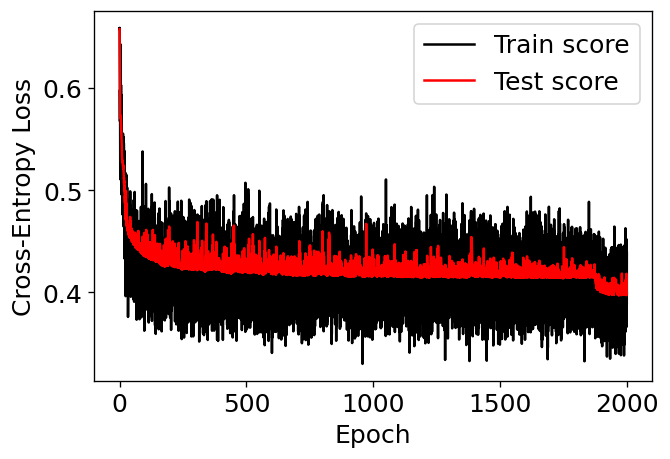

250 0.8918406072106262 0.6794758213362864
500 0.8937381404174574 0.67750092284976
750 0.8690702087286527 0.6575858250276855
1000 0.8975332068311196 0.6826688815060908
1250 0.8956356736242884 0.6937615356220007
1500 0.8975332068311196 0.6963455149501662
1750 0.8937381404174574 0.6911775562938354
---------------------------------------------


100%|██████████| 2000/2000 [02:01<00:00, 16.49it/s]


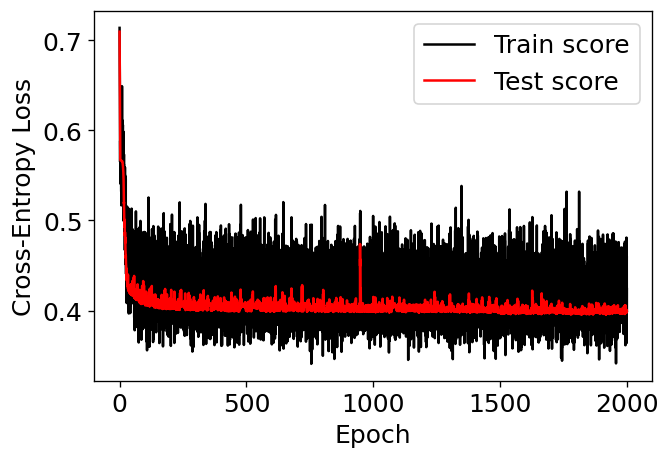

250 0.9070208728652751 0.6736736166495766
500 0.9108159392789373 0.6689263605635942
750 0.9070208728652751 0.6785917739546542
1000 0.9013282732447818 0.6266947704226957
1250 0.9089184060721063 0.6712999886065854
1500 0.9146110056925996 0.6838517336979226
1750 0.9146110056925996 0.6986062056131556
---------------------------------------------
ARCH = VDFCNN_6060_CNN2_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 94.4+/-5.161395160225576
TN = 378.6+/-9.54148835350125
FP = 12.6+/-6.560487786742691
FN = 41.4+/-2.5768197453450252
Acc = 0.8975332068311197+/-0.010867416366813144
TSS = 0.6623632090022653+/-0.018063961083938204
=>=>=> NUMBER OF EPOCHS: 500
TP = 95.8+/-3.8678159211627436
TN = 378.8+/-9.195651146058118
FP = 12.4+/-6.529931086925803
FN = 40.0+/-2.0
Acc = 0.9005692599620494+/-0.012156066321098261
TSS = 0.6734533905291032+/-0.016982035564803863
=>=>=> NUMBER OF EPOCHS: 750
TP = 96.2+/-4.66476151587624
TN = 377.2+/-13.89100428334827
FP = 14.0+/-11.081516141756055
FN = 39.6+/-1.8547236990991

In [23]:
# NETWORK: VDFCNN_6060_CNN2_CONN2
ARCH = 'VDFCNN_6060_CNN2_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN2_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:55<00:00, 17.31it/s]


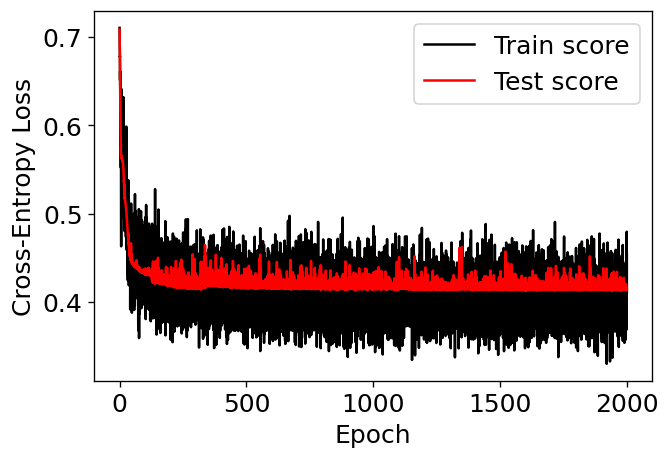

250 0.889943074003795 0.6535628411129346
500 0.8785578747628083 0.6433151406434868
750 0.9032258064516129 0.6763100645013549
1000 0.9013282732447818 0.6687912675088737
1250 0.8975332068311196 0.6686958513033854
1500 0.9013282732447818 0.6638105415823823
1750 0.9013282732447818 0.673771993435365
---------------------------------------------


100%|██████████| 2000/2000 [01:56<00:00, 17.15it/s]


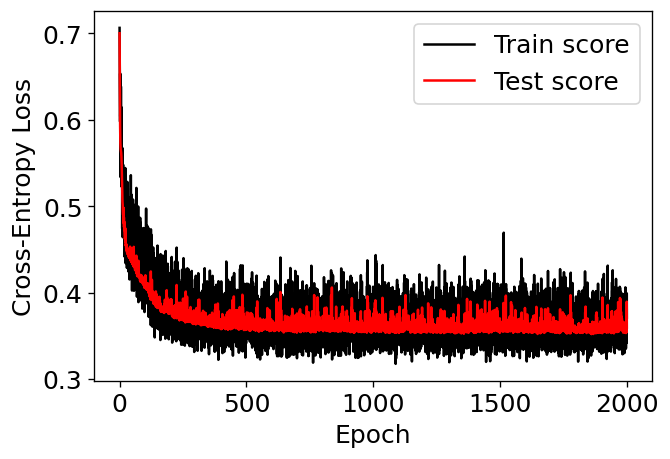

250 0.9240986717267552 0.8187855425365445
500 0.9563567362428842 0.8469905728788977
750 0.9544592030360531 0.874336857371856
1000 0.9582542694497154 0.869451547650853
1250 0.9639468690702088 0.8671043089958398
1500 0.9601518026565465 0.8520667150108774
1750 0.9430740037950665 0.7843975420785466
---------------------------------------------


100%|██████████| 2000/2000 [01:57<00:00, 17.05it/s]


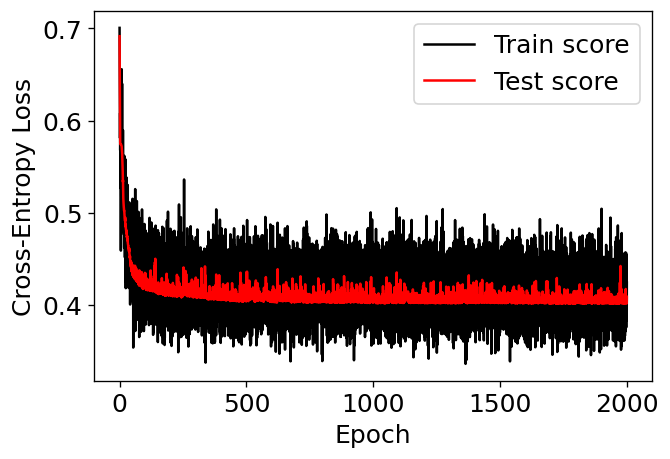

250 0.905123339658444 0.6772231699176741
500 0.8994307400379506 0.6787250611881629
750 0.9108159392789373 0.6849551286805607
1000 0.905123339658444 0.6864570199510495
1250 0.9127134724857685 0.6875324482681896
1500 0.9146110056925996 0.6993436178891939
1750 0.9146110056925996 0.6947266928725061
---------------------------------------------


100%|██████████| 2000/2000 [01:56<00:00, 17.21it/s]


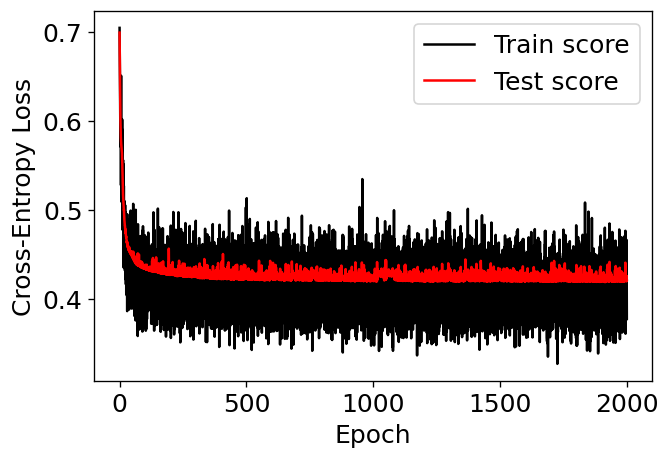

250 0.889943074003795 0.6176264304171281
500 0.8861480075901328 0.6124584717607973
750 0.8918406072106262 0.6202104097452934
1000 0.8937381404174574 0.6319121447028424
1250 0.8842504743833017 0.6189922480620156
1500 0.8823529411764706 0.6164082687338501
1750 0.8975332068311196 0.6325212255444814
---------------------------------------------


100%|██████████| 2000/2000 [01:56<00:00, 17.10it/s]


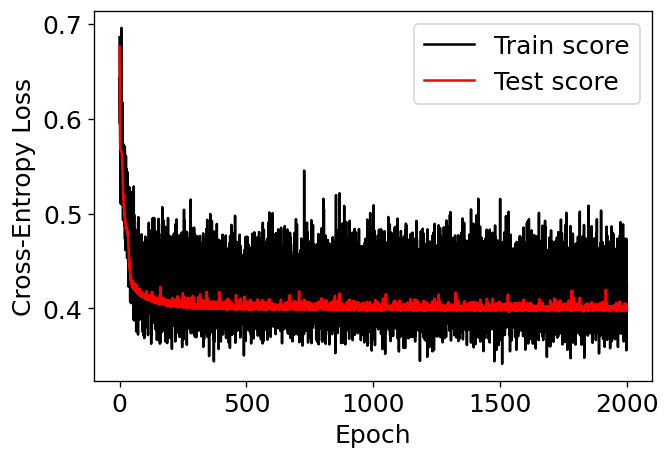

250 0.8994307400379506 0.6634954996012304
500 0.9108159392789373 0.688598989783905
750 0.9146110056925996 0.693688048308078
1000 0.9089184060721063 0.6860544605218184
1250 0.9089184060721063 0.6762181459116631
1500 0.9127134724857685 0.6763890471307584
1750 0.9146110056925996 0.6838517336979226
---------------------------------------------
ARCH = VDFCNN_6060_CNN2_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 97.8+/-9.927738916792684
TN = 377.4+/-4.079215610874228
FP = 13.8+/-6.4
FN = 38.0+/-11.679041056525147
Acc = 0.901707779886148+/-0.012609675693234281
TSS = 0.6861386967171023+/-0.06919899378096271
=>=>=> NUMBER OF EPOCHS: 500
TP = 98.2+/-8.51821577561874
TN = 379.4+/-7.391887445030531
FP = 11.8+/-7.19444229944198
FN = 37.6+/-10.34601372510205
Acc = 0.9062618595825427+/-0.02738239697540408
TSS = 0.69401764725105+/-0.08110065880782955
=>=>=> NUMBER OF EPOCHS: 750
TP = 99.0+/-10.825894882179487
TN = 383.2+/-2.039607805437114
FP = 8.0+/-2.898275349237888
FN = 36.8+/-12.687001221722966
Acc = 

In [24]:
# NETWORK: VDFCNN_6060_CNN2_CONN1
ARCH = 'VDFCNN_6060_CNN2_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN2_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:41<00:00, 19.74it/s]


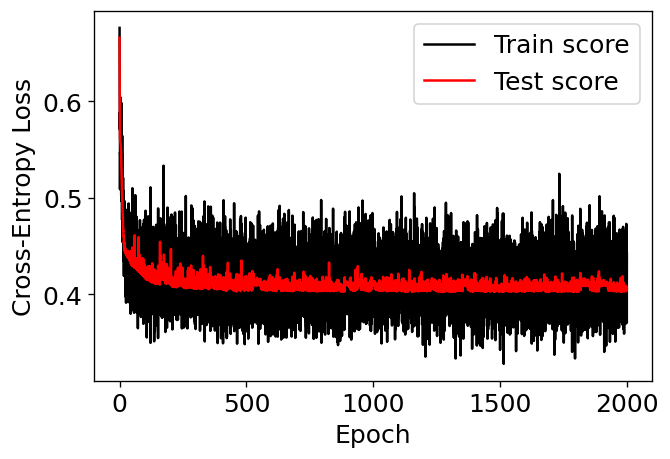

250 0.9089184060721063 0.6739628258463417
500 0.9089184060721063 0.6789435517728332
750 0.9013282732447818 0.6687912675088737
1000 0.905123339658444 0.668886683714362
1250 0.9108159392789373 0.681481622838823
1500 0.9127134724857685 0.6790389679783214
1750 0.9032258064516129 0.6713293385748635
---------------------------------------------


100%|██████████| 2000/2000 [01:42<00:00, 19.47it/s]


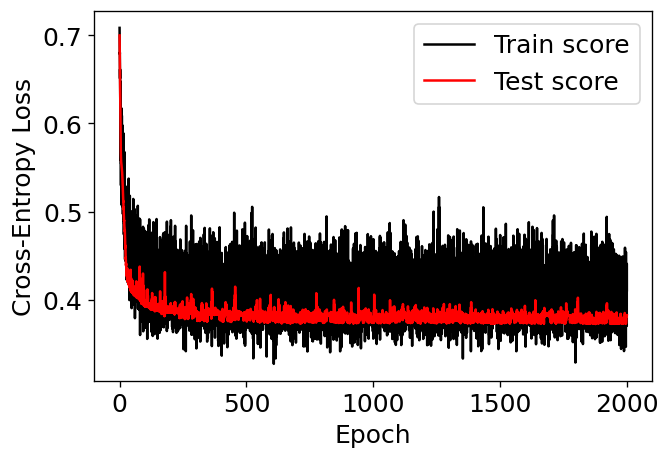

250 0.9297912713472486 0.7317659631311781
500 0.9392789373814042 0.7693599480935842
750 0.9316888045540797 0.7691691156826076
1000 0.9392789373814042 0.7693599480935842
1250 0.937381404174573 0.7867447807335598
1500 0.9449715370018975 0.7919163390710278
1750 0.9259962049335864 0.7466127247051639
---------------------------------------------


100%|██████████| 2000/2000 [01:41<00:00, 19.64it/s]


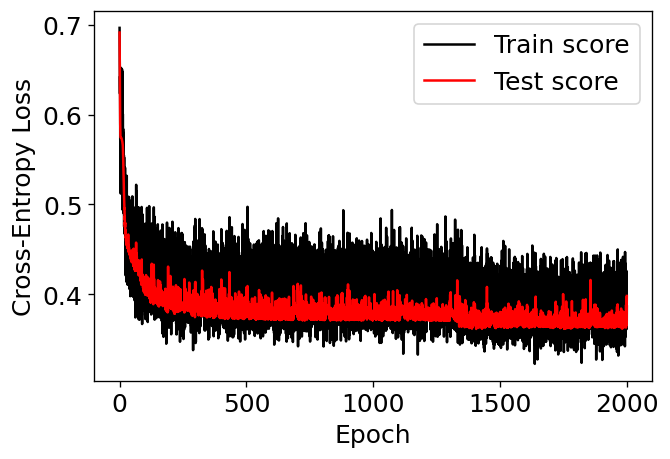

250 0.9411764705882353 0.8092968923830007
500 0.9089184060721063 0.76548245939331
750 0.9354838709677419 0.7830972335533635
1000 0.9449715370018975 0.8098346065415709
1250 0.9335863377609108 0.7989876140324853
1500 0.9392789373814042 0.820570347845435
1750 0.9392789373814042 0.7882518727286213
---------------------------------------------


100%|██████████| 2000/2000 [01:41<00:00, 19.65it/s]


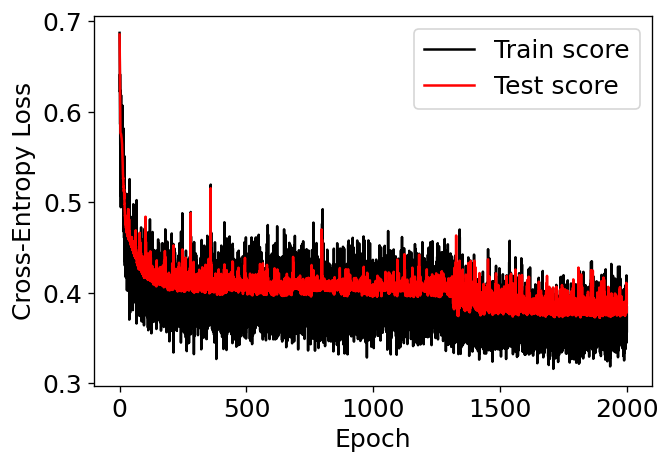

250 0.9070208728652751 0.6955887781469177
500 0.9032258064516129 0.690420819490587
750 0.920303605313093 0.7319121447028424
1000 0.9165085388994307 0.7267441860465116
1250 0.9146110056925996 0.728719084533038
1500 0.9297912713472486 0.7904208194905868
1750 0.9316888045540797 0.7838870431893687
---------------------------------------------


100%|██████████| 2000/2000 [01:42<00:00, 19.46it/s]


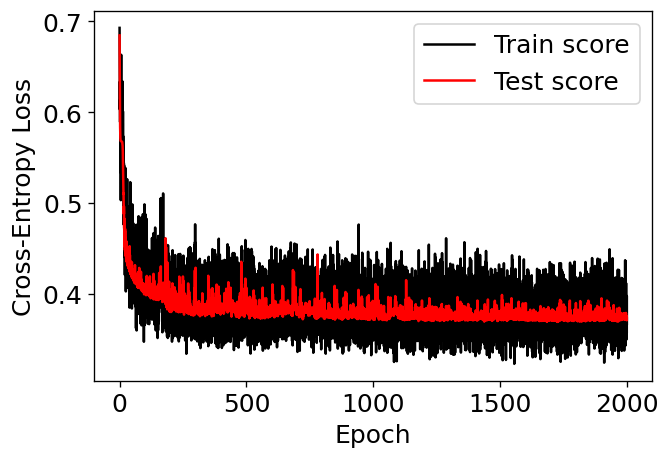

250 0.9184060721062619 0.7676313091033383
500 0.9089184060721063 0.7598268200979834
750 0.9316888045540797 0.7608522274125555
1000 0.9354838709677419 0.8102047016824275
1250 0.9278937381404174 0.8049447419391592
1500 0.9411764705882353 0.8030838175534541
1750 0.937381404174573 0.7783221298089704
---------------------------------------------
ARCH = VDFCNN_6060_CNN1_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 103.0+/-8.12403840463596
TN = 382.4+/-6.3118935352238
FP = 8.8+/-5.2687759489277965
FN = 32.8+/-7.05407683541936
Acc = 0.9210626185958255+/-0.012903225806451615
TSS = 0.7356491537221552+/-0.04872774072308226
=>=>=> NUMBER OF EPOCHS: 500
TP = 104.4+/-7.578918128598566
TN = 377.2+/-10.419213022104886
FP = 14.0+/-8.763560920082657
FN = 31.4+/-6.974238309665077
Acc = 0.9138519924098671+/-0.012903225806451632
TSS = 0.7328067197696596+/-0.03957709866002834
=>=>=> NUMBER OF EPOCHS: 750
TP = 103.6+/-5.851495535331117
TN = 383.4+/-2.65329983228432
FP = 7.8+/-2.2271057451320084
FN = 32.2+/-4.6647

In [25]:
# NETWORK: VDFCNN_6060_CNN1_CONN2
ARCH = 'VDFCNN_6060_CNN1_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN1_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:38<00:00, 20.33it/s]


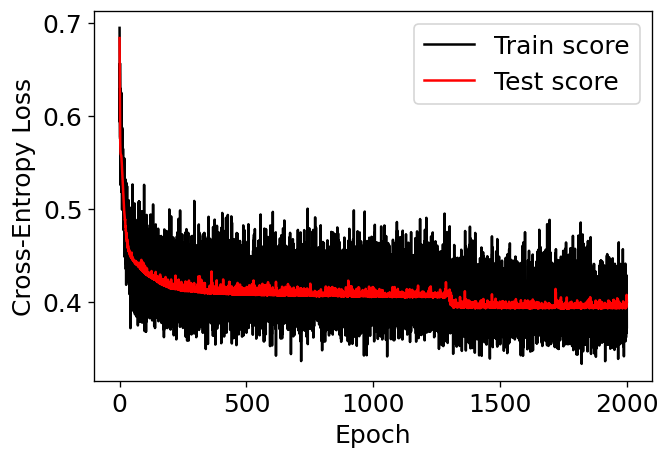

250 0.905123339658444 0.6639059577878708
500 0.9127134724857685 0.6790389679783214
750 0.9089184060721063 0.6739628258463417
1000 0.9089184060721063 0.6689820999198504
1250 0.9108159392789373 0.681481622838823
1500 0.920303605313093 0.7091141559482462
1750 0.9240986717267552 0.7241517499332086
---------------------------------------------


100%|██████████| 2000/2000 [01:46<00:00, 18.81it/s]


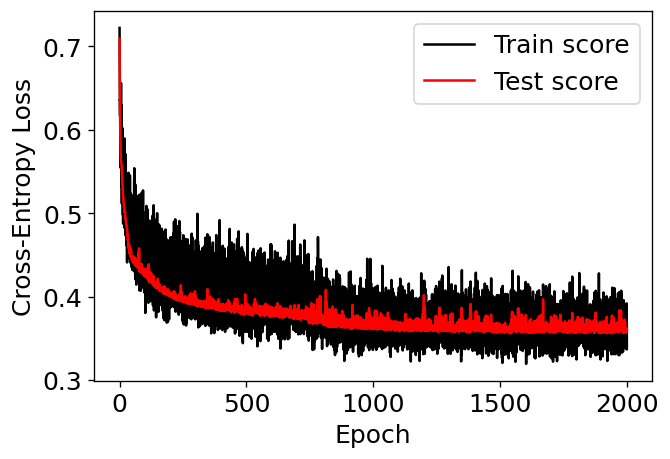

250 0.9259962049335864 0.7715163543376207
500 0.9278937381404174 0.7541315216976452
750 0.9449715370018975 0.821800694629976
1000 0.9506641366223909 0.8443570856074196
1250 0.9449715370018975 0.7919163390710278
1500 0.9544592030360531 0.8494332277393992
1750 0.9582542694497154 0.8794129995038357
---------------------------------------------


100%|██████████| 2000/2000 [01:41<00:00, 19.78it/s]


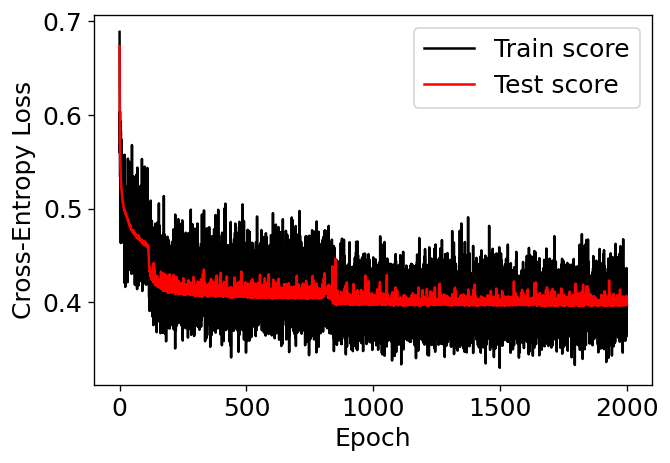

250 0.9013282732447818 0.6720685307424163
500 0.9108159392789373 0.6849551286805607
750 0.9146110056925996 0.6993436178891939
1000 0.9222011385199241 0.7235036712897723
1250 0.9146110056925996 0.7039605429058815
1500 0.9222011385199241 0.72812059630646
1750 0.9184060721062619 0.7044982570644516
---------------------------------------------


100%|██████████| 2000/2000 [01:53<00:00, 17.67it/s]


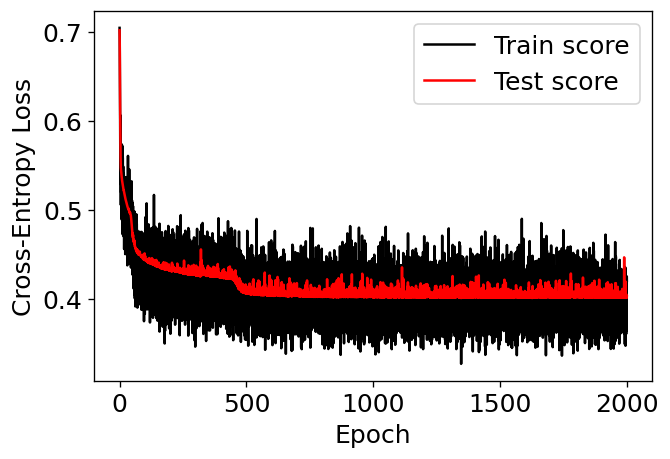

250 0.889943074003795 0.6814507198228129
500 0.9032258064516129 0.6949796973052786
750 0.9127134724857685 0.7078995939461056
1000 0.9184060721062619 0.7247692875599853
1250 0.9146110056925996 0.7150424510889628
1500 0.9127134724857685 0.7170173495754891
1750 0.9184060721062619 0.7202104097452935
---------------------------------------------


100%|██████████| 2000/2000 [01:54<00:00, 17.46it/s]


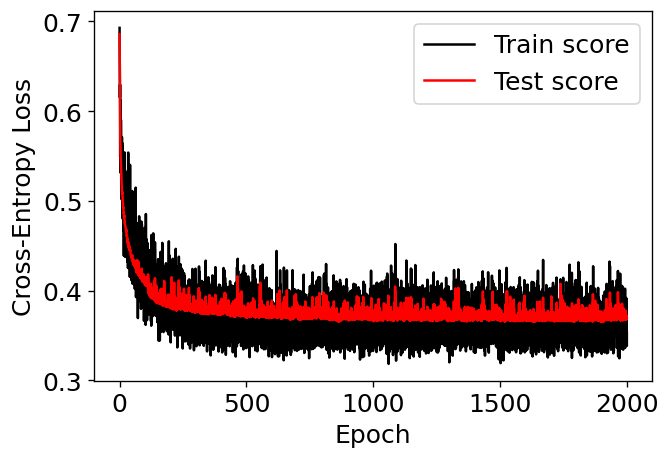

250 0.937381404174573 0.8078310736394364
500 0.9430740037950665 0.8056283468155406
750 0.9392789373814042 0.79562113098629
1000 0.9506641366223909 0.840397250389275
1250 0.9487666034155597 0.8280164065170331
1500 0.9468690702087287 0.8254718772549466
1750 0.9430740037950665 0.8105465041206182
---------------------------------------------
ARCH = VDFCNN_6060_CNN1_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 102.0+/-7.37563556583431
TN = 378.6+/-6.8
FP = 12.6+/-4.498888751680798
FN = 33.8+/-8.304215796810677
Acc = 0.911954459203036+/-0.01724981886506796
TSS = 0.7193545272660314+/-0.05881524191008653
=>=>=> NUMBER OF EPOCHS: 500
TP = 100.8+/-6.04648658313239
TN = 383.8+/-5.268775948927796
FP = 7.4+/-3.0066592756745814
FN = 35.0+/-6.928203230275509
Acc = 0.9195445920303605+/-0.014230233972867325
TSS = 0.7237467324954694+/-0.04890592852979855
=>=>=> NUMBER OF EPOCHS: 750
TP = 102.8+/-7.138627319029898
TN = 384.2+/-2.9257477676655586
FP = 7.0+/-1.0954451150103321
FN = 33.0+/-8.318653737234168
Acc 

In [26]:
# NETWORK: VDFCNN_6060_CNN1_CONN1
ARCH = 'VDFCNN_6060_CNN1_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN1_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))